# Lungs Cancer TCGA Genoma Classification using Neural Networking, PCA, Random Forest

# Import Libraries 

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

# Neural network libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Load Dataset

In [2]:
tcga_lungs = pd.read_csv("TCGA_Lungs_Indexed.csv")
tcga_lungs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 70 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   project                                               1026 non-null   object 
 1   submitter_id                                          1026 non-null   object 
 2   synchronous_malignancy                                1026 non-null   object 
 3   ajcc_pathologic_stage                                 1014 non-null   object 
 4   days_to_diagnosis                                     982 non-null    float64
 5   created_datetime                                      0 non-null      float64
 6   last_known_disease_status                             1026 non-null   object 
 7   tissue_or_organ_of_origin                             1026 non-null   object 
 8   days_to_last_follow_up                                784 

In [3]:
tcga_lungs.shape

(1026, 70)

# 2. Data Cleaning

## 2.1. Drop Columns with More than 50% NA Values

In [4]:
threshold       = 0.5 
columns_with_NA = tcga_lungs.columns[tcga_lungs.isna().mean() > threshold]
print("Columns with more then 50% NA Values: \n\n", columns_with_NA)
# Drop the columns
tcga_lungs_cleaned = tcga_lungs.drop(columns = columns_with_NA, axis=1)
tcga_lungs_cleaned.shape

Columns with more then 50% NA Values: 

 Index(['created_datetime', 'days_to_last_known_disease_status',
       'days_to_recurrence', 'years_smoked', 'alcohol_intensity',
       'year_of_death', 'days_to_death',
       'treatments_pharmaceutical_treatment_intent_type',
       'treatments_pharmaceutical_therapeutic_agents',
       'treatments_pharmaceutical_days_to_treatment_end',
       'treatments_pharmaceutical_days_to_treatment_start',
       'treatments_pharmaceutical_regimen_or_line_of_therapy',
       'treatments_pharmaceutical_treatment_effect',
       'treatments_pharmaceutical_initial_disease_status',
       'treatments_pharmaceutical_treatment_anatomic_site',
       'treatments_pharmaceutical_treatment_outcome',
       'treatments_radiation_treatment_intent_type',
       'treatments_radiation_therapeutic_agents',
       'treatments_radiation_days_to_treatment_end',
       'treatments_radiation_days_to_treatment_start',
       'treatments_radiation_regimen_or_line_of_therapy',

(1026, 45)

## 2. Drop Columns with "_id" in Their Names

In [5]:
id_columns      = [columns for columns in tcga_lungs_cleaned.columns if "_id" in columns]
print("Columns with '_id' in Their Names: \n\n", id_columns)
# Drop the _id columns
tcga_lungs_cleaned = tcga_lungs_cleaned.drop(columns = id_columns)
tcga_lungs_cleaned.shape

Columns with '_id' in Their Names: 

 ['submitter_id', 'diagnosis_id', 'exposure_id', 'demographic_id', 'treatments_pharmaceutical_treatment_id', 'treatments_radiation_treatment_id']


(1026, 39)

## 2.3 Drop Unused Columns

In [6]:
# Columns to drop
columns_to_drop = ['project', 'updated_datetime', 'treatments_pharmaceutical_treatment_type',
                   'treatments_radiation_treatment_type', 'bcr_patient_barcode', 'alcohol_history',
                   'progression_or_recurrence', 'tumor_grade', 'classification_of_tumor',
                   'last_known_disease_status', 'icd_10_code', 'state', 'days_to_diagnosis', 'days_to_birth', 'year_of_birth', 'morphology']
tcga_lungs_cleaned = tcga_lungs_cleaned.drop(columns = columns_to_drop)
tcga_lungs_cleaned.shape

(1026, 23)

## 2.4 Impute Missing Values

In [7]:
tcga_lungs_cleaned.replace(["Not Reported", "not reported"], np.nan, inplace=True)

In [8]:
tcga_lungs_cleaned.isnull().mean() * 100

synchronous_malignancy                             9.161793
ajcc_pathologic_stage                              1.169591
tissue_or_organ_of_origin                          0.000000
days_to_last_follow_up                            23.586745
age_at_diagnosis                                   3.996101
primary_diagnosis                                  0.000000
prior_malignancy                                   0.097466
year_of_diagnosis                                  2.631579
prior_treatment                                    0.097466
ajcc_staging_system_edition                       12.085770
ajcc_pathologic_t                                  0.000000
ajcc_pathologic_n                                  0.097466
ajcc_pathologic_m                                  0.779727
site_of_resection_or_biopsy                        0.000000
cigarettes_per_day                                23.684211
pack_years_smoked                                 23.684211
race                                    

In [7]:
# Impute missing values in object columns with mode
object_columns = tcga_lungs_cleaned.select_dtypes(include='object').columns
tcga_lungs_cleaned[object_columns] = tcga_lungs_cleaned[object_columns].fillna(tcga_lungs_cleaned[object_columns].mode().iloc[0])

# Impute missing values in numerical columns with mean
numerical_columns = tcga_lungs_cleaned.select_dtypes(include=['float64']).columns
tcga_lungs_cleaned[numerical_columns] = tcga_lungs_cleaned[numerical_columns].fillna(tcga_lungs_cleaned[numerical_columns].mean())

tcga_lungs_cleaned.isnull().sum()

# Save the cleaned dataset to a new CSV file
tcga_lungs_cleaned.to_csv("tcga_lungs_cleaned.csv", index=False)

# 3. Descriptive Statistics

In [8]:
tcga_lungs_cleaned.describe().round(2) 

,days_to_last_follow_up,age_at_diagnosis,year_of_diagnosis,cigarettes_per_day,pack_years_smoked,age_at_index
count,1026.00,1026.00,1026.00,1026.00,1026.00,1026.00
mean,904.85,24385.58,2008.00,2.62,47.84,66.30
std,824.50,3359.03,4.12,1.43,26.11,9.26
min,0.00,12179.00,1991.00,0.01,0.15,33.00
25%,440.00,22218.25,2006.00,1.64,30.00,60.00
50%,900.00,24609.00,2009.00,2.62,47.84,67.00
75%,928.75,26806.75,2011.00,2.84,51.75,73.00
max,7248.00,32872.00,2013.00,13.15,240.00,90.00


In [9]:
tcga_lungs_cleaned.describe(include=object).T 

,count,unique,top,freq
synchronous_malignancy,1026,2,No,1011
ajcc_pathologic_stage,1026,10,Stage IB,304
tissue_or_organ_of_origin,1026,6,"Upper lobe, lung",563
primary_diagnosis,1026,18,"Squamous cell carcinoma, NOS",469
prior_malignancy,1026,2,no,878
prior_treatment,1026,2,No,1016
ajcc_staging_system_edition,1026,5,7th,614
ajcc_pathologic_t,1026,9,T2,345
ajcc_pathologic_n,1026,5,N0,656
ajcc_pathologic_m,1026,5,M0,775


# 4. Trasnform Columns for Data Preprocessing Pipelines

In [10]:
tcga_lungs_cleaned["ajcc_pathologic_stage"].value_counts()

Stage IB      304
Stage IA      224
Stage IIB     168
Stage IIIA    137
Stage IIA     115
Stage IV       33
Stage IIIB     30
Stage I         8
Stage II        4
Stage III       3
Name: ajcc_pathologic_stage, dtype: int64

In [11]:
# Trasnform "ajcc_pathologic_stage" for Invasive and Non-Invasive Cancer Stagging
def map_to_binary_label(stage):
    # Define the stages considered invasive
    invasive_stages = ['Stage IIA', 'Stage IIB', 'Stage IIIA', 'Stage IIIB', 'Stage IV']
    
    # Map to labels: 'Invasive' for invasive stages, 'Non-Invasive' for others
    return 'Invasive' if stage in invasive_stages else 'Non-Invasive'

# Apply the mapping function to create a new target column with labels
tcga_lungs_cleaned['cancer_stagging'] = tcga_lungs_cleaned['ajcc_pathologic_stage'].apply(map_to_binary_label)
tcga_lungs_cleaned = tcga_lungs_cleaned.drop("ajcc_pathologic_stage", axis=1)

tcga_lungs_cleaned = tcga_lungs_cleaned.assign(primary_diagnosis = tcga_lungs_cleaned['primary_diagnosis'].str.split(', ')).explode('primary_diagnosis').reset_index(drop=True)

tissueOrgan_mappingDict = {
    'Upper lobe, lung': 'Upper lobe',
    'Lower lobe, lung': 'Lower lobe',
    'Lung, NOS': 'NOS',
    'Middle lobe, lung': 'Middle lobe',
    'Overlapping lesion of lung': 'Overlapping lesion',
    'Main bronchus': 'Main bronchus'
}

ethnicity_mappingDict = {
    'not hispanic or latino' : 'not hispanic' ,
    'hispanic or latino'     : 'hispanic'}

race_mappingDict = {'white' : 'white',
                    'black or african american' : 'black',
                    'asian' : 'asian',
                    'american indian or alaska native' : 'american indian'}

tcga_lungs_cleaned['tissue_or_organ_of_origin']   = tcga_lungs_cleaned['tissue_or_organ_of_origin'].replace(tissueOrgan_mappingDict)
tcga_lungs_cleaned['site_of_resection_or_biopsy'] = tcga_lungs_cleaned['site_of_resection_or_biopsy'].replace(tissueOrgan_mappingDict)
tcga_lungs_cleaned['ethnicity']                   = tcga_lungs_cleaned['ethnicity'].replace(ethnicity_mappingDict)
tcga_lungs_cleaned['race']                        = tcga_lungs_cleaned['race'].replace(race_mappingDict)

# 5. Data Preprocessing Pipelines

## 5.1. Extract Features and Target

In [12]:
tcga_lungs_cleaned_cp = tcga_lungs_cleaned.copy()
features              = tcga_lungs_cleaned_cp.drop('cancer_stagging', axis=1)
target                = tcga_lungs_cleaned_cp['cancer_stagging']

## 5.2. Define Pipelines

In [13]:
### Select categorical columns
categorical_Columns = ['synchronous_malignancy', 'tissue_or_organ_of_origin', 'prior_malignancy', 'prior_treatment',
                       'ajcc_staging_system_edition', 'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
                       'site_of_resection_or_biopsy', 'race', 'gender', 'ethnicity', 'vital_status', 
                       'treatments_pharmaceutical_treatment_or_therapy','treatments_radiation_treatment_or_therapy'] 

### Select numerical columns
numerical_Columns = ['days_to_last_follow_up', 'age_at_diagnosis', 'year_of_diagnosis','cigarettes_per_day', 
                     'pack_years_smoked', 'age_at_index'] 

categorical_pipeline = Pipeline( steps = [("ohe", OneHotEncoder())])
numerical_Pipeline   = Pipeline( steps = [("impute", SimpleImputer(strategy="mean")) ,("scale", RobustScaler())])
### Make ColumnTransformer
transformation_pipeline = ColumnTransformer(transformers=[("numerical", numerical_Pipeline, numerical_Columns),
                                    ("categorical", categorical_pipeline, categorical_Columns)])
transformation_pipeline

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', RobustScaler())]),
                                 ['days_to_last_follow_up', 'age_at_diagnosis',
                                  'year_of_diagnosis', 'cigarettes_per_day',
                                  'pack_years_smoked', 'age_at_index']),
                                ('categorical',
                                 Pipeline(steps=[('ohe', OneHotEncoder())]),
                                 ['synchronous_malignancy',
                                  'tissue_or_organ_of_origin',
                                  'prior_malignancy', 'prior_treatment',
                                  'ajcc_staging_system_edition',
                                  'ajcc_pathologic_t', 'ajcc_pathologic_n',
                                  'ajcc_pathologic_m',
                                  'site_of_resection_or_biopsy', 'race',
                                  'gender', 'ethnicity', 'vital_status',
                                  'treatments_pharmaceutical_treatment_or_therapy',
                                  'treatments_radiation_treatment_or_therapy'])])

## 5.3. Train test split

In [14]:
# Apply train test split
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    stratify = target,
                                                    test_size=0.3,
                                                    random_state=42)

print("Traning Data Size\t:", X_train.shape, "||", y_train.shape, "\n")
print("Testing Data Size\t:", X_test.shape, "||", y_test.shape)

Traning Data Size	: (1337, 22) || (1337,) 

Testing Data Size	: (573, 22) || (573,)


## 5.4. Feature's Transformation

In [16]:
X_train_processed = transformation_pipeline.fit_transform(X_train)
X_test_processed  = transformation_pipeline.transform(X_test)

# 6. Random Forest Classifier

In [17]:
randomForest = RandomForestClassifier(max_depth=8, 
                                          class_weight='balanced_subsample', 
                                          random_state=42)
randomForest.fit(X_train_processed,y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       random_state=42)

In [18]:
rf_prediction_test  = randomForest.predict(X_test_processed)
rf_prediction_train = randomForest.predict(X_train_processed)

In [19]:
print(classification_report(y_test, rf_prediction_test))

              precision    recall  f1-score   support

    Invasive       0.98      0.94      0.96       267
Non-Invasive       0.95      0.98      0.97       306

    accuracy                           0.97       573
   macro avg       0.97      0.96      0.96       573
weighted avg       0.97      0.97      0.97       573



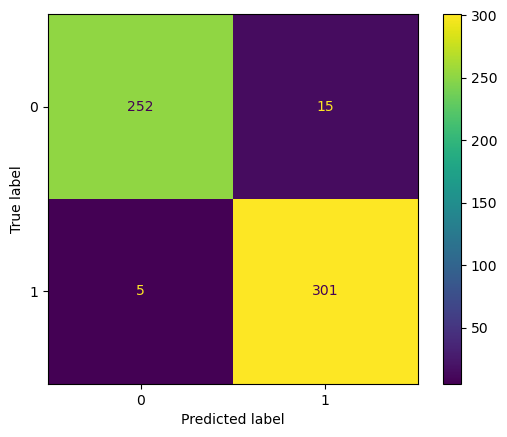

<Figure size 800x400 with 0 Axes>

In [20]:
rf_cm  = confusion_matrix(y_test, rf_prediction_test)
cm_dip = ConfusionMatrixDisplay(confusion_matrix = rf_cm,
                                       display_labels=['0','1'])
cm_dip.plot()
plt.figure(figsize = (8,4))
plt.show()

## 6.3. Evaludation on Training Set

In [22]:
rf_accuracy_train   = accuracy_score(y_train, rf_prediction_train)
rf_recall_train     = recall_score(y_train, rf_prediction_train, average='micro')
rf_precision_train  = precision_score(y_train, rf_prediction_train, average='micro')
rf_f1_Score_train   = f1_score(y_train, rf_prediction_train, average='micro')

print("Random Forest Evaludation on Training Set \n\n")
print("Accuracy :\t", round(rf_accuracy_train, 4))
print("Recall :\t", round(rf_recall_train, 4))
print("Precision :\t", round(rf_precision_train, 4))
print("F1 - Score :\t", round(rf_f1_Score_train, 4))

Random Forest Evaludation on Training Set 


Accuracy :	 0.9903
Recall :	 0.9903
Precision :	 0.9903
F1 - Score :	 0.9903


## 6.4. Evaludation on Testing Set

In [23]:
rf_accuracy_test   = accuracy_score(y_test, rf_prediction_test)
rf_recall_test     = recall_score(y_test, rf_prediction_test, average='micro')
rf_precision_test  = precision_score(y_test, rf_prediction_test, average='micro')
rf_f1_Score_test   = f1_score(y_test, rf_prediction_test, average='micro')

print("Random Forest Evaludation on Testing Set \n\n")
print("Accuracy :\t", round(rf_accuracy_test, 4))
print("Recall :\t", round(rf_recall_test, 4))
print("Precision :\t", round(rf_precision_test, 4))
print("F1 - Score :\t", round(rf_f1_Score_test, 4))

Random Forest Evaludation on Testing Set 


Accuracy :	 0.9651
Recall :	 0.9651
Precision :	 0.9651
F1 - Score :	 0.9651


# 7. Artifical Neural Network with PCA

## 7.1. Define Neural Network

In [28]:
def neural_network(input_features):
    optimizer = Adam(learning_rate = 0.001)
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_dim=input_features.shape[1]))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=2, activation='softmax'))
    model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def split_data(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        stratify     = target,
                                                        test_size    = 0.3,
                                                        random_state = 42
    )
    return X_train, X_test, y_train, y_test

## 7.2. Data Preprocessing Pipeline

In [25]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse=False)

PCA_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_Columns),
        ('cat', categorical_transformer, categorical_Columns)
    ])

PCA_preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['days_to_last_follow_up', 'age_at_diagnosis',
                                  'year_of_diagnosis', 'cigarettes_per_day',
                                  'pack_years_smoked', 'age_at_index']),
                                ('cat',
                                 OneHotEncoder(drop='first', sparse=False),
                                 ['synchronous_malignancy',
                                  'tissue_or_organ_of_origin',
                                  'prior_malignancy', 'prior_treatment',
                                  'ajcc_staging_system_edition',
                                  'ajcc_pathologic_t', 'ajcc_pathologic_n',
                                  'ajcc_pathologic_m',
                                  'site_of_resection_or_biopsy', 'race',
                                  'gender', 'ethnicity', 'vital_status',
                                  'treatments_pharmaceutical_treatment_or_therapy',
                                  'treatments_radiation_treatment_or_therapy'])])

## 7.3. 5-PCA

### 7.3.1 PCA Analysis with 5 Principle Components

In [26]:
pca_5 = PCA(n_components=5)
# Define the pipeline with PCA
pca_pipeline_5 = Pipeline(steps=[
    ('preprocessor', PCA_preprocessor),
    ('pca', pca_5)
])
pca_pipeline_5

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['days_to_last_follow_up',
                                                   'age_at_diagnosis',
                                                   'year_of_diagnosis',
                                                   'cigarettes_per_day',
                                                   'pack_years_smoked',
                                                   'age_at_index']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['synchronous_malignancy',
                                                   'tissue_or_organ_of_origin',
                                                   'prior_malignancy',
                                                   'prior_treatment',
                                                   'ajcc_staging_system_edition',
                                                   'ajcc_pathologic_t',
                                                   'ajcc_pathologic_n',
                                                   'ajcc_pathologic_m',
                                                   'site_of_resection_or_biopsy',
                                                   'race', 'gender',
                                                   'ethnicity', 'vital_status',
                                                   'treatments_pharmaceutical_treatment_or_therapy',
                                                   'treatments_radiation_treatment_or_therapy'])])),
                ('pca', PCA(n_components=5))])

In [27]:
features_pca_5 = pca_pipeline_5.fit_transform(features)
features_pca_5

array([[ 1.11498856, -1.32825152, -1.28033604,  0.59152214,  0.80970087],
       [-1.09275354,  0.59521765, -1.01275394, -0.81672505,  0.95012363],
       [-1.09275354,  0.59521765, -1.01275394, -0.81672505,  0.95012363],
       ...,
       [-1.78743903,  0.73850813,  1.31196355,  0.45495646,  0.77381876],
       [-1.78743903,  0.73850813,  1.31196355,  0.45495646,  0.77381876],
       [-1.51955998,  1.63214279, -0.6006511 ,  0.51453149,  0.90259103]])

### 7.3.2 Model Training

In [29]:
X_train, X_test, y_train, y_test = split_data(features_pca_5, target)
y_train_dummies = pd.get_dummies(y_train)
y_test_dummies  = pd.get_dummies(y_test)
pca_5_model     = neural_network(X_train)
pca_5_history   = pca_5_model.fit(X_train, y_train_dummies, validation_data = (X_test, y_test_dummies), epochs = 200, batch_size = 32)


Epoch 1/200


42/42 [==============================] - 2s 9ms/step - loss: 0.6860 - accuracy: 0.5587 - val_loss: 0.6564 - val_accuracy: 0.6248
Epoch 2/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.5931 - val_loss: 0.6533 - val_accuracy: 0.6318
Epoch 3/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6620 - accuracy: 0.6066 - val_loss: 0.6496 - val_accuracy: 0.6195
Epoch 4/200
42/42 [==============================] - 0s 3ms/step - loss: 0.6568 - accuracy: 0.6051 - val_loss: 0.6507 - val_accuracy: 0.6248
Epoch 5/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6495 - accuracy: 0.6260 - val_loss: 0.6488 - val_accuracy: 0.6230
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.6456 - accuracy: 0.6193 - val_loss: 0.6433 - val_accuracy: 0.6283
Epoch 7/200
42/42 [==============================] - 0s 5ms/step - loss: 0.6362 - accuracy: 0.6425 - val_loss: 0.6488 - val_accuracy: 0.6265
Epoch 8/20

In [30]:
pca_5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 11170 (43.63 KB)
Trainable params: 11170 (43.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


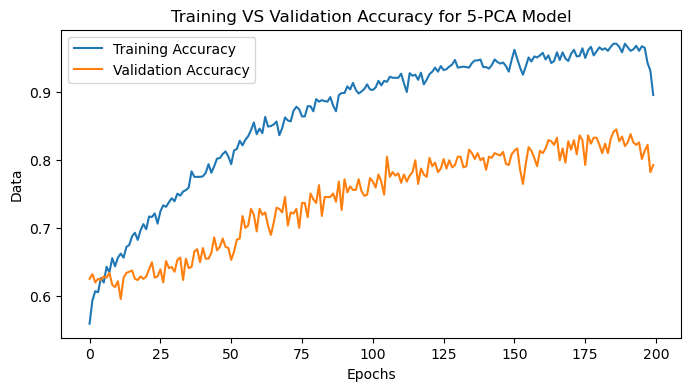

In [31]:
plt.figure(figsize = (8,4))
plt.plot(pca_5_history.history["accuracy"], label = "Training Accuracy")
plt.plot(pca_5_history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Training VS Validation Accuracy for 5-PCA Model", fontsize = 12)
plt.xlabel("Epochs")
plt.ylabel("Data")
plt.legend()
plt.show()

### 7.3.3 Model Evaluation 

In [32]:
pca_5_prediction_test  = pca_5_model.predict(X_test)
pca_5_prediction_train = pca_5_model.predict(X_train)

42/42 [==============================] - 0s 3ms/step


#### 7.3.4.1 Classification Report

In [33]:
class_labels     = ['Invasive', 'Non-Invasive']
pca_5_prediction_test  = [class_labels[label] for label in np.argmax(pca_5_prediction_test, axis=1)]
pca_5_prediction_train = [class_labels[label] for label in np.argmax(pca_5_prediction_train, axis=1)]
print(classification_report(y_test, pca_5_prediction_test))

              precision    recall  f1-score   support

    Invasive       0.83      0.70      0.76       267
Non-Invasive       0.77      0.88      0.82       306

    accuracy                           0.79       573
   macro avg       0.80      0.79      0.79       573
weighted avg       0.80      0.79      0.79       573



#### 7.3.4.2 Confusion Matrix

<Figure size 800x400 with 0 Axes>

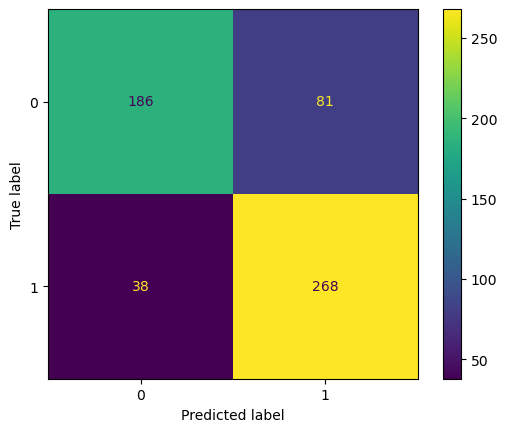

In [34]:
pca_5_cm     = confusion_matrix(y_test, pca_5_prediction_test)
pca_5_cm_dip = ConfusionMatrixDisplay(confusion_matrix = pca_5_cm,
                                       display_labels=['0','1'])
plt.figure(figsize = (8,4))
pca_5_cm_dip.plot()
plt.show()

#### 7.3.4.3 Evaludation on Training Set

In [36]:
pca_5_accuracy_train   = accuracy_score(y_train, pca_5_prediction_train)
pca_5_recall_train     = recall_score(y_train, pca_5_prediction_train, average='micro')
pca_5_precision_train  = precision_score(y_train, pca_5_prediction_train, average='micro')
pca_5_f1_Score_train   = f1_score(y_train, pca_5_prediction_train, average='micro')

print("Evaludation on Training Set \n")
print("Accuracy :\t", round(pca_5_accuracy_train, 4))
print("Recall :\t", round(pca_5_recall_train, 4))
print("Precision :\t", round(pca_5_precision_train, 4))
print("F1 - Score :\t", round(pca_5_f1_Score_train, 4))

Evaludation on Training Set 

Accuracy :	 0.9065
Recall :	 0.9065
Precision :	 0.9065
F1 - Score :	 0.9065


#### 7.3.4.4 Evaludation on Testing Set

In [37]:
pca_5_accuracy_test   = accuracy_score(y_test, pca_5_prediction_test)
pca_5_recall_test     = recall_score(y_test, pca_5_prediction_test, average='micro')
pca_5_precision_test  = precision_score(y_test, pca_5_prediction_test, average='micro')
pca_5_f1_Score_test   = f1_score(y_test, pca_5_prediction_test, average='micro')

print("Evaludation on Training Set \n")
print("Accuracy :\t", round(pca_5_accuracy_test, 4))
print("Recall :\t", round(pca_5_recall_test, 4))
print("Precision :\t", round(pca_5_precision_test, 4))
print("F1 - Score :\t", round(pca_5_f1_Score_test, 4))

Evaludation on Training Set 

Accuracy :	 0.7923
Recall :	 0.7923
Precision :	 0.7923
F1 - Score :	 0.7923


## 7.4. 7-PCA

### 7.4.1 PCA Analysis with 7 Principle Components

In [38]:
pca_7 = PCA(n_components=7)
# Define the pipeline with PCA
pca_pipeline_7 = Pipeline(steps=[
    ('preprocessor', PCA_preprocessor),
    ('pca', pca_7)
])
pca_pipeline_7

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['days_to_last_follow_up',
                                                   'age_at_diagnosis',
                                                   'year_of_diagnosis',
                                                   'cigarettes_per_day',
                                                   'pack_years_smoked',
                                                   'age_at_index']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['synchronous_malignancy',
                                                   'tissue_or_organ_of_origin',
                                                   'prior_malignancy',
                                                   'prior_treatment',
                                                   'ajcc_staging_system_edition',
                                                   'ajcc_pathologic_t',
                                                   'ajcc_pathologic_n',
                                                   'ajcc_pathologic_m',
                                                   'site_of_resection_or_biopsy',
                                                   'race', 'gender',
                                                   'ethnicity', 'vital_status',
                                                   'treatments_pharmaceutical_treatment_or_therapy',
                                                   'treatments_radiation_treatment_or_therapy'])])),
                ('pca', PCA(n_components=7))])

In [39]:
features_pca_7 = pca_pipeline_7.fit_transform(features)
features_pca_7

array([[ 1.11499438, -1.32824777, -1.28031212, ...,  0.81393489,
        -0.06307935,  0.29460778],
       [-1.09275438,  0.59521544, -1.01275722, ...,  0.94905829,
         0.21632232,  0.922351  ],
       [-1.09275438,  0.59521544, -1.01275722, ...,  0.94905829,
         0.21632232,  0.922351  ],
       ...,
       [-1.78744052,  0.73850551,  1.3119579 , ...,  0.77207614,
         0.53229347, -0.74139232],
       [-1.78744052,  0.73850551,  1.3119579 , ...,  0.77207614,
         0.53229347, -0.74139232],
       [-1.51956185,  1.6321431 , -0.60065427, ...,  0.9008707 ,
         0.3004711 , -0.06104505]])

### 7.4.2 Model Training

In [40]:
X_train, X_test, y_train, y_test = split_data(features_pca_7, target)
y_train_dummies = pd.get_dummies(y_train)
y_test_dummies  = pd.get_dummies(y_test)
pca_7_model     = neural_network(X_train)
pca_7_history   = pca_7_model.fit(X_train, y_train_dummies, validation_data = (X_test, y_test_dummies), epochs = 200, batch_size = 32)

Epoch 1/200
42/42 [==============================] - 2s 10ms/step - loss: 0.6196 - accuracy: 0.6724 - val_loss: 0.5414 - val_accuracy: 0.7574
Epoch 2/200
42/42 [==============================] - 0s 5ms/step - loss: 0.4855 - accuracy: 0.7756 - val_loss: 0.5137 - val_accuracy: 0.7487
Epoch 3/200
42/42 [==============================] - 0s 5ms/step - loss: 0.4505 - accuracy: 0.7988 - val_loss: 0.5051 - val_accuracy: 0.7522
Epoch 4/200
42/42 [==============================] - 0s 5ms/step - loss: 0.4355 - accuracy: 0.7966 - val_loss: 0.5031 - val_accuracy: 0.7627
Epoch 5/200
42/42 [==============================] - 0s 5ms/step - loss: 0.4182 - accuracy: 0.8063 - val_loss: 0.4977 - val_accuracy: 0.7661
Epoch 6/200
42/42 [==============================] - 0s 4ms/step - loss: 0.4113 - accuracy: 0.8108 - val_loss: 0.4945 - val_accuracy: 0.7469
Epoch 7/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3999 - accuracy: 0.8138 - val_loss: 0.4925 - val_accuracy: 0.7766
Epoch 8/200


In [41]:
pca_7_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1024      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 11426 (44.63 KB)
Trainable params: 11426 (44.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


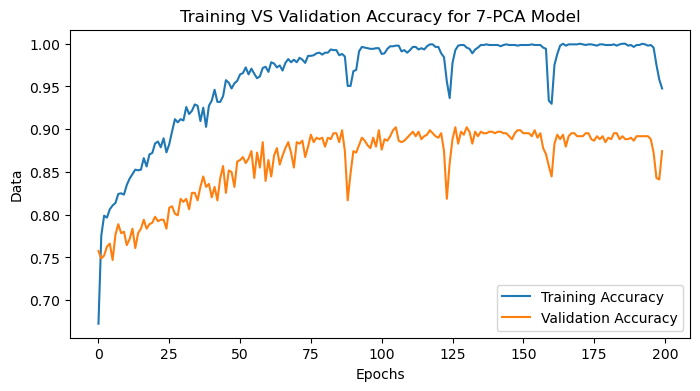

In [42]:
plt.figure(figsize = (8,4))
plt.plot(pca_7_history.history["accuracy"], label = "Training Accuracy")
plt.plot(pca_7_history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Training VS Validation Accuracy for 7-PCA Model", fontsize = 12)
plt.xlabel("Epochs")
plt.ylabel("Data")
plt.legend()
plt.show()

### 7.4.3 Model Evaluation

In [43]:
pca_7_prediction_test  = pca_7_model.predict(X_test)
pca_7_prediction_train = pca_7_model.predict(X_train)
pca_7_prediction_test  = [class_labels[label] for label in np.argmax(pca_7_prediction_test, axis=1)]
pca_7_prediction_train = [class_labels[label] for label in np.argmax(pca_7_prediction_train, axis=1)]

42/42 [==============================] - 0s 2ms/step


#### 7.4.3.1 Classification Report

In [44]:
print(classification_report(y_test, pca_7_prediction_test))

              precision    recall  f1-score   support

    Invasive       0.86      0.88      0.87       267
Non-Invasive       0.89      0.87      0.88       306

    accuracy                           0.87       573
   macro avg       0.87      0.87      0.87       573
weighted avg       0.87      0.87      0.87       573



#### 7.4.3.2 Confusion Matrix

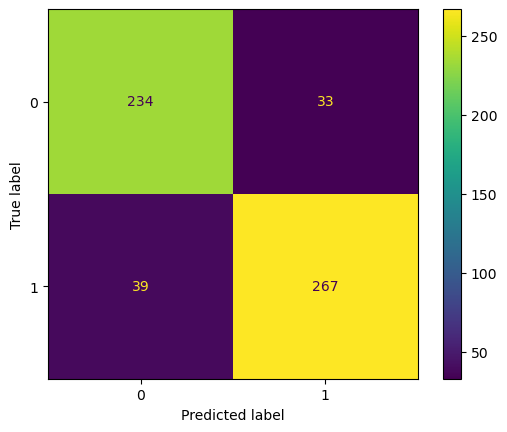

In [45]:
pca_7_cm     = confusion_matrix(y_test, pca_7_prediction_test)
pca_7_cm_dip = ConfusionMatrixDisplay(confusion_matrix = pca_7_cm,
                                       display_labels=['0','1'])
pca_7_cm_dip.plot()
plt.show()

#### 7.4.3.3 Evaludation on Training Set

In [46]:
pca_7_accuracy_train   = accuracy_score(y_train, pca_7_prediction_train)
pca_7_recall_train     = recall_score(y_train, pca_7_prediction_train, average='micro')
pca_7_precision_train  = precision_score(y_train, pca_7_prediction_train, average='micro')
pca_7_f1_Score_train   = f1_score(y_train, pca_7_prediction_train, average='micro')

print("Evaludation on Training Set \n")
print("Accuracy :\t", round(pca_7_accuracy_train, 4))
print("Recall :\t", round(pca_7_accuracy_train, 4))
print("Precision :\t", round(pca_7_accuracy_train, 4))
print("F1 - Score :\t", round(pca_7_accuracy_train, 4))

Evaludation on Training Set 

Accuracy :	 0.9566
Recall :	 0.9566
Precision :	 0.9566
F1 - Score :	 0.9566


#### 7.4.3.4 Evaludation on Testing Set

In [47]:
pca_7_accuracy_test   = accuracy_score(y_test, pca_7_prediction_test)
pca_7_recall_test     = recall_score(y_test, pca_7_prediction_test, average='micro')
pca_7_precision_test  = precision_score(y_test, pca_7_prediction_test, average='micro')
pca_7_f1_Score_test   = f1_score(y_test, pca_7_prediction_test, average='micro')

print("Evaludation on Training Set \n")
print("Accuracy :\t", round(pca_7_accuracy_test, 4))
print("Recall :\t", round(pca_7_recall_test, 4))
print("Precision :\t", round(pca_7_precision_test, 4))
print("F1 - Score :\t", round(pca_7_f1_Score_test, 4))

Evaludation on Training Set 

Accuracy :	 0.8743
Recall :	 0.8743
Precision :	 0.8743
F1 - Score :	 0.8743


## 7.5. 9-PCA

### 7.5.1 PCA Analysis with 9 Principle Components

In [48]:
pca_9 = PCA(n_components=9)
# Define the pipeline with PCA
pca_pipeline_9 = Pipeline(steps=[
    ('preprocessor', PCA_preprocessor),
    ('pca', pca_9)
])
pca_pipeline_9

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['days_to_last_follow_up',
                                                   'age_at_diagnosis',
                                                   'year_of_diagnosis',
                                                   'cigarettes_per_day',
                                                   'pack_years_smoked',
                                                   'age_at_index']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['synchronous_malignancy',
                                                   'tissue_or_organ_of_origin',
                                                   'prior_malignancy',
                                                   'prior_treatment',
                                                   'ajcc_staging_system_edition',
                                                   'ajcc_pathologic_t',
                                                   'ajcc_pathologic_n',
                                                   'ajcc_pathologic_m',
                                                   'site_of_resection_or_biopsy',
                                                   'race', 'gender',
                                                   'ethnicity', 'vital_status',
                                                   'treatments_pharmaceutical_treatment_or_therapy',
                                                   'treatments_radiation_treatment_or_therapy'])])),
                ('pca', PCA(n_components=9))])

In [49]:
features_pca_9 = pca_pipeline_9.fit_transform(features)
features_pca_9

array([[ 1.11499377, -1.32824592, -1.28030561, ...,  0.29277155,
         0.87328163,  0.1047245 ],
       [-1.09275474,  0.59521339, -1.01275617, ...,  0.92447905,
        -0.32850399, -0.0995093 ],
       [-1.09275474,  0.59521339, -1.01275617, ...,  0.92447905,
        -0.32850399, -0.0995093 ],
       ...,
       [-1.78744035,  0.73850411,  1.31195582, ..., -0.74065188,
         0.23836645, -0.50300583],
       [-1.78744035,  0.73850411,  1.31195582, ..., -0.74065188,
         0.23836645, -0.50300583],
       [-1.51956148,  1.63214056, -0.60065952, ..., -0.05959015,
        -0.285406  ,  0.34936346]])

### 7.5.2 Model Training

In [50]:
X_train, X_test, y_train, y_test = split_data(features_pca_9, target)
y_train_dummies = pd.get_dummies(y_train)
y_test_dummies  = pd.get_dummies(y_test)
pca_9_model     = neural_network(X_train)
pca_9_history   = pca_9_model.fit(X_train, y_train_dummies, validation_data = (X_test, y_test_dummies), epochs = 200, batch_size = 32)

Epoch 1/200
42/42 [==============================] - 2s 11ms/step - loss: 0.6037 - accuracy: 0.7158 - val_loss: 0.5417 - val_accuracy: 0.7400
Epoch 2/200
42/42 [==============================] - 0s 5ms/step - loss: 0.4667 - accuracy: 0.8010 - val_loss: 0.5136 - val_accuracy: 0.7435
Epoch 3/200
42/42 [==============================] - 0s 4ms/step - loss: 0.4449 - accuracy: 0.8070 - val_loss: 0.4937 - val_accuracy: 0.7661
Epoch 4/200
42/42 [==============================] - 0s 4ms/step - loss: 0.4220 - accuracy: 0.8108 - val_loss: 0.4777 - val_accuracy: 0.7818
Epoch 5/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3985 - accuracy: 0.8242 - val_loss: 0.4740 - val_accuracy: 0.7801
Epoch 6/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3823 - accuracy: 0.8340 - val_loss: 0.4708 - val_accuracy: 0.7906
Epoch 7/200
42/42 [==============================] - 0s 5ms/step - loss: 0.3624 - accuracy: 0.8384 - val_loss: 0.4569 - val_accuracy: 0.7836
Epoch 8/200


In [51]:
pca_9_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1280      
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 11682 (45.63 KB)
Trainable params: 11682 (45.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


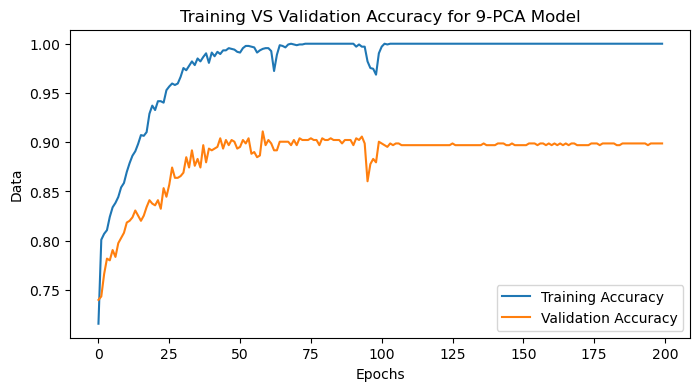

In [52]:
plt.figure(figsize = (8,4))
plt.plot(pca_9_history.history["accuracy"], label = "Training Accuracy")
plt.plot(pca_9_history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Training VS Validation Accuracy for 9-PCA Model", fontsize = 12)
plt.xlabel("Epochs")
plt.ylabel("Data")
plt.legend()
plt.show()

### 7.5.3 Model Evaluation

In [53]:
pca_9_prediction_test  = pca_9_model.predict(X_test)
pca_9_prediction_train = pca_9_model.predict(X_train)
pca_9_prediction_test  = [class_labels[label] for label in np.argmax(pca_9_prediction_test, axis=1)]
pca_9_prediction_train = [class_labels[label] for label in np.argmax(pca_9_prediction_train, axis=1)]

42/42 [==============================] - 0s 2ms/step


#### 7.5.3.1 Classification Report

In [54]:
print(classification_report(y_test, pca_9_prediction_test))

              precision    recall  f1-score   support

    Invasive       0.92      0.86      0.89       267
Non-Invasive       0.89      0.93      0.91       306

    accuracy                           0.90       573
   macro avg       0.90      0.90      0.90       573
weighted avg       0.90      0.90      0.90       573



#### 7.5.3.2 Confusion Matrix

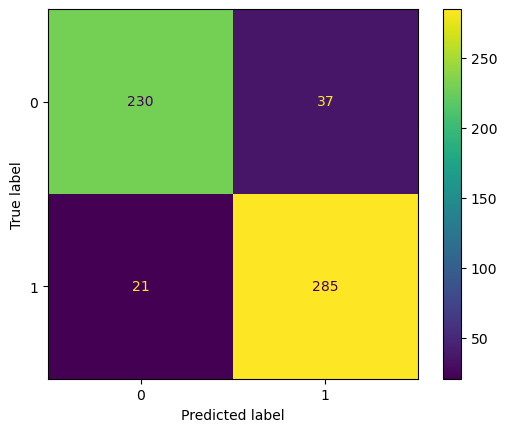

In [55]:
pca_9_cm     = confusion_matrix(y_test, pca_9_prediction_test)
pca_9_cm_dip = ConfusionMatrixDisplay(confusion_matrix = pca_9_cm,
                                       display_labels=['0','1'])
pca_9_cm_dip.plot()
plt.show()

#### 7.5.3.3 Evaludation on Training Set

In [56]:
pca_9_accuracy_train   = accuracy_score(y_train, pca_9_prediction_train)
pca_9_recall_train     = recall_score(y_train, pca_9_prediction_train, average='micro')
pca_9_precision_train  = precision_score(y_train, pca_9_prediction_train, average='micro')
pca_9_f1_Score_train   = f1_score(y_train, pca_9_prediction_train, average='micro')

print("Evaludation on Training Set \n")
print("Accuracy :\t", round(pca_9_accuracy_train, 4))
print("Recall :\t", round(pca_9_recall_train, 4))
print("Precision :\t", round(pca_9_precision_train, 4))
print("F1 - Score :\t", round(pca_9_f1_Score_train, 4))

Evaludation on Training Set 

Accuracy :	 1.0
Recall :	 1.0
Precision :	 1.0
F1 - Score :	 1.0


#### 7.5.3.4 Evaludation on Testing Set

In [57]:
pca_9_accuracy_test   = accuracy_score(y_test, pca_9_prediction_test)
pca_9_recall_test     = recall_score(y_test, pca_9_prediction_test, average='micro')
pca_9_precision_test  = precision_score(y_test, pca_9_prediction_test, average='micro')
pca_9_f1_Score_test   = f1_score(y_test, pca_9_prediction_test, average='micro')

print("Evaludation on Training Set \n")
print("Accuracy :\t", round(pca_9_accuracy_test, 4))
print("Recall :\t", round(pca_9_recall_test, 4))
print("Precision :\t", round(pca_9_precision_test, 4))
print("F1 - Score :\t", round(pca_9_f1_Score_test, 4))

Evaludation on Training Set 

Accuracy :	 0.8988
Recall :	 0.8988
Precision :	 0.8988
F1 - Score :	 0.8988


# 8. Model Comparison

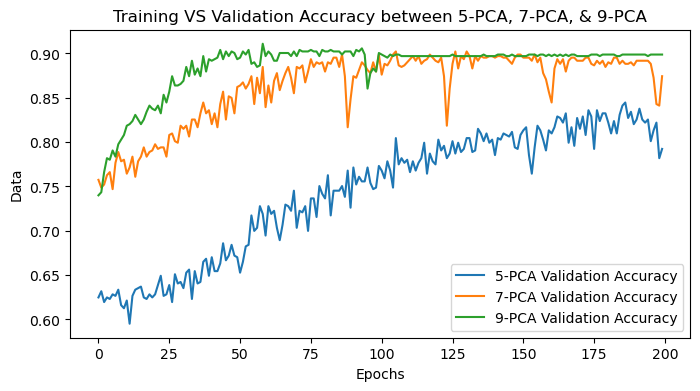

In [58]:
plt.figure(figsize = (8,4))
plt.plot(pca_5_history.history["val_accuracy"], label = "5-PCA Validation Accuracy")
plt.plot(pca_7_history.history["val_accuracy"], label = "7-PCA Validation Accuracy")
plt.plot(pca_9_history.history["val_accuracy"], label = "9-PCA Validation Accuracy")
plt.title("Validation Accuracy between 5-PCA, 7-PCA, & 9-PCA", fontsize = 12)
plt.xlabel("Epochs")
plt.ylabel("Data")
plt.legend()
plt.show()